In [ ]:
#| hide
!pip install -Uqq nixtla utilsforecast statsforecast

In [ ]:
#| hide 
from nixtla.utils import in_colab

In [ ]:
#| hide 
IN_COLAB = in_colab()

In [ ]:
#| hide
if not IN_COLAB:
    from nixtla.utils import colab_badge
    from dotenv import load_dotenv

# Forecasting Intermittent Demand

In this tutorial, we show how to use TimeGPT on an intermittent series where we have many values at zero. Here, we use a subset of the M5 dataset that tracks the demand for food items in a Californian store. The dataset also includes exogenous variables like the sell price and the type of event occuring at a particular day.

TimeGPT achieves the best performance at a MAE of 0.49, which represents a **14% improvement** over the best statistical model specifically built to handle intermittent time series data.

Predicting with TimeGPT took 6.8 seconds, while fitting and predicting with statistical models took 5.2 seconds. TimeGPT is technically slower, but for a difference in time of roughly 1 second only, we get much better predictions with TimeGPT.

In [ ]:
#| echo: false
if not IN_COLAB:
    load_dotenv()
    colab_badge('docs/tutorials/4_intermittent_demand')

[![](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Nixtla/nixtla/blob/main/nbs/docs/tutorials/4_intermittent_demand.ipynb)

## Initial setup

We start off by importing the required packages for this tutorial and create an instace of `NixtlaClient`.

In [ ]:
import time
import pandas as pd
import numpy as np

from nixtla import NixtlaClient

from utilsforecast.losses import mae
from utilsforecast.evaluation import evaluate

In [ ]:
nixtla_client = NixtlaClient(
    # defaults to os.environ.get("NIXTLA_API_KEY")
    api_key = 'my_api_key_provided_by_nixtla'
)

> 👍 Use an Azure AI endpoint
> 
> To use an Azure AI endpoint, remember to set also the `base_url` argument:
> 
> `nixtla_client = NixtlaClient(base_url="you azure ai endpoint", api_key="your api_key")`

In [ ]:
#| hide
if not IN_COLAB:
    nixtla_client = NixtlaClient()

We now read the dataset and plot it.

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/Nixtla/transfer-learning-time-series/main/datasets/m5_sales_exog_small.csv")
df['ds'] = pd.to_datetime(df['ds'])

df.head()

,unique_id,ds,y,sell_price,event_type_Cultural,event_type_National,event_type_Religious,event_type_Sporting
0,FOODS_1_001,2011-01-29,3,2.0,0,0,0,0
1,FOODS_1_001,2011-01-30,0,2.0,0,0,0,0
2,FOODS_1_001,2011-01-31,0,2.0,0,0,0,0
3,FOODS_1_001,2011-02-01,1,2.0,0,0,0,0
4,FOODS_1_001,2011-02-02,4,2.0,0,0,0,0


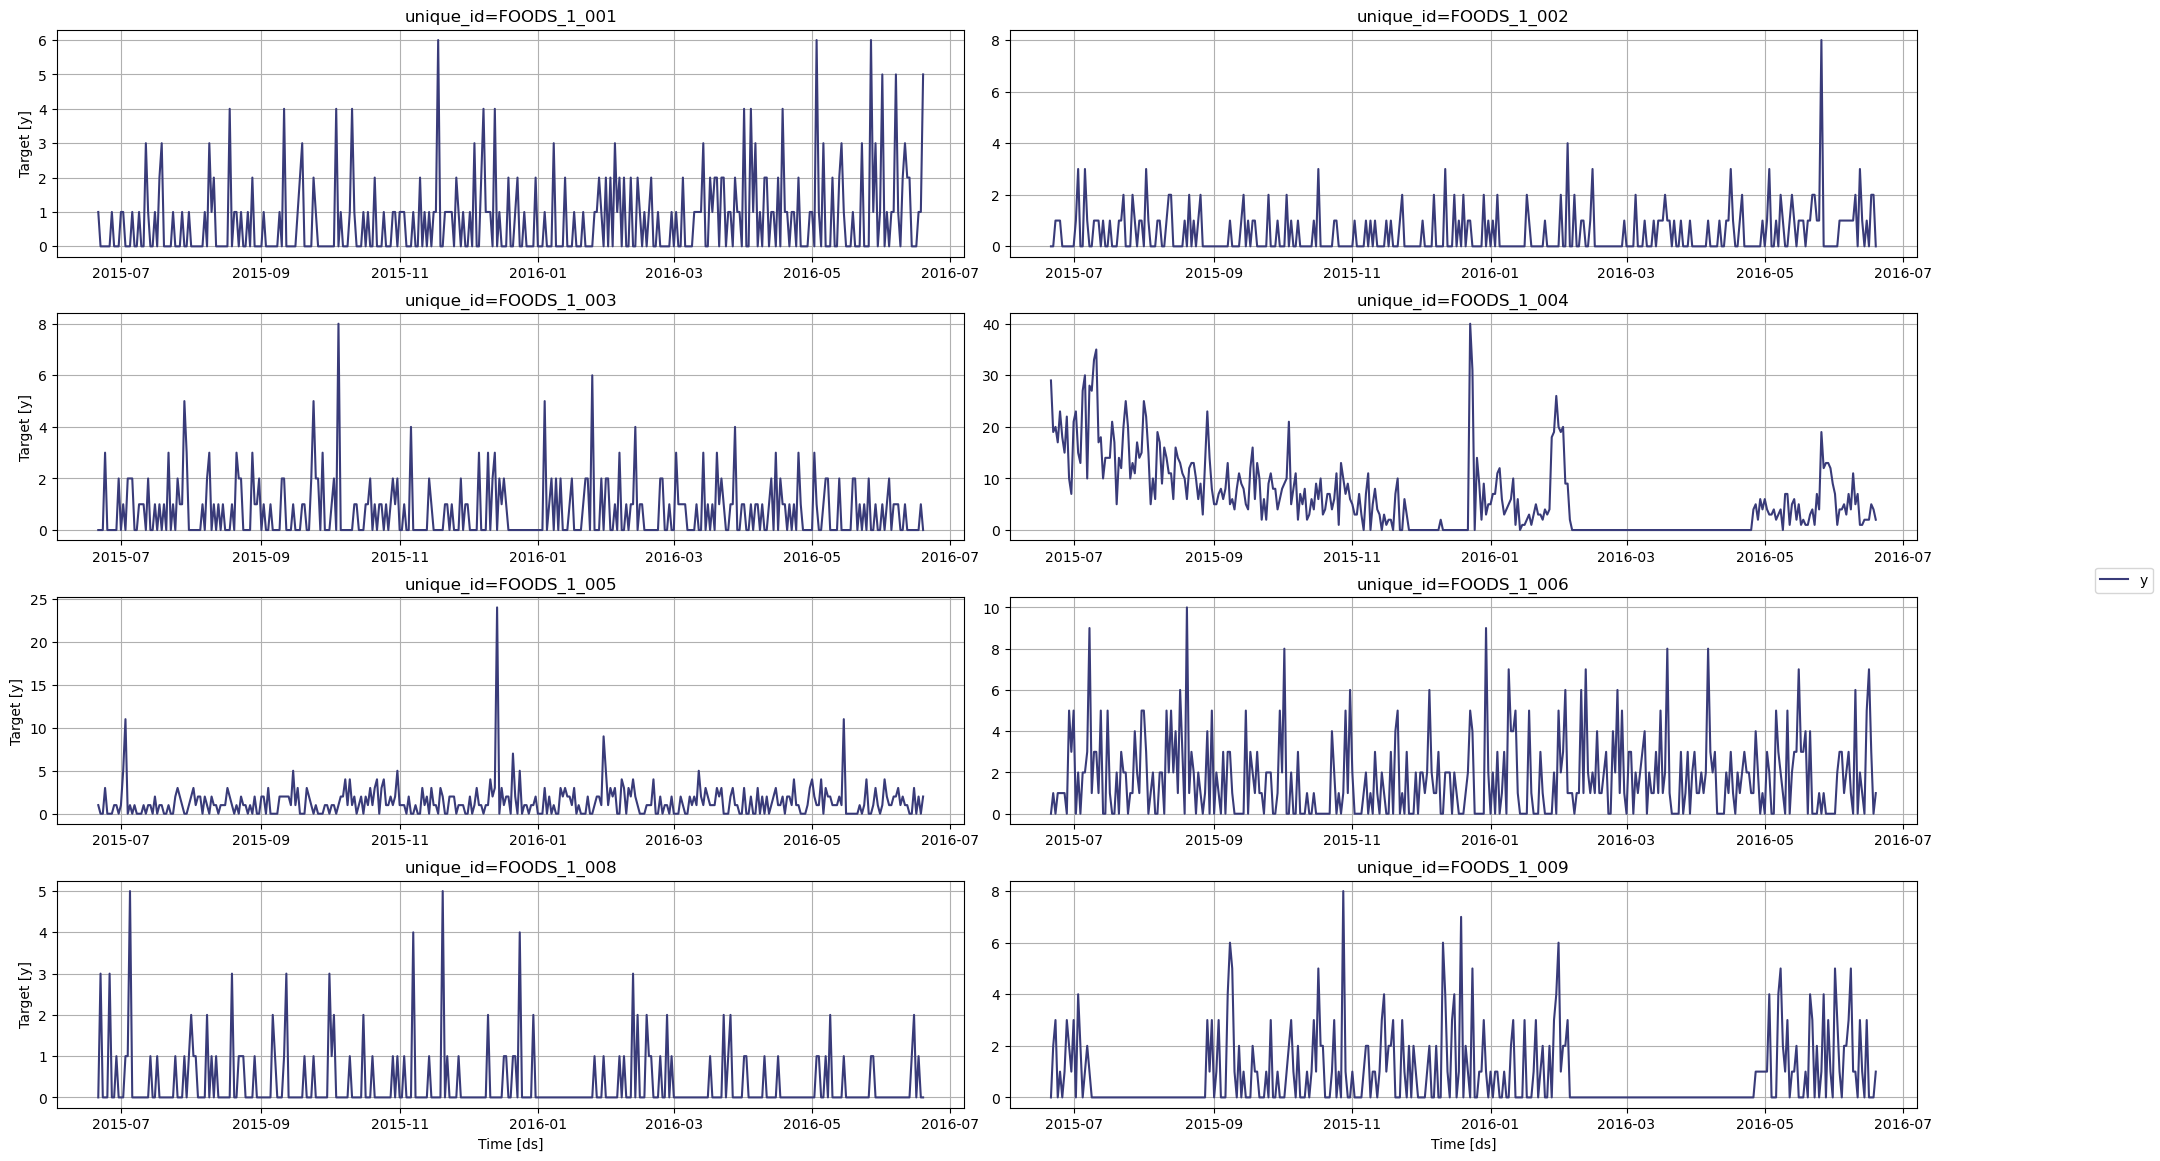

In [ ]:
nixtla_client.plot(
    df, 
    max_insample_length=365, 
)

In the figure above, we can see the intermittent nature of this dataset, with many periods with zero demand.

Now, let's use TimeGPT to forecast the demand of each product.

## Bounded forecasts

To avoid getting negative predictions coming from the model, we use a log transformation on the data. That way, the model will be forced to predict only positive values.

Note that due to the presence of zeros in our dataset, we add one to all points before taking the log.

In [ ]:
df_transformed = df.copy()

df_transformed['y'] = np.log(df_transformed['y']+1)

df_transformed.head()

,unique_id,ds,y,sell_price,event_type_Cultural,event_type_National,event_type_Religious,event_type_Sporting
0,FOODS_1_001,2011-01-29,1.386294,2.0,0,0,0,0
1,FOODS_1_001,2011-01-30,0.000000,2.0,0,0,0,0
2,FOODS_1_001,2011-01-31,0.000000,2.0,0,0,0,0
3,FOODS_1_001,2011-02-01,0.693147,2.0,0,0,0,0
4,FOODS_1_001,2011-02-02,1.609438,2.0,0,0,0,0


Now, let's keep the last 28 time steps for the test set and use the rest as input to the model.

In [ ]:
test_df = df_transformed.groupby('unique_id').tail(28)                                                      

input_df = df_transformed.drop(test_df.index).reset_index(drop=True)

## Forecasting with TimeGPT

In [ ]:
start = time.time()

fcst_df = nixtla_client.forecast(
    df=input_df,
    h=28,                            
    level=[80],                        # Generate a 80% confidence interval
    finetune_steps=10,                 # Specify the number of steps for fine-tuning
    finetune_loss='mae',               # Use the MAE as the loss function for fine-tuning
    model='timegpt-1-long-horizon',    # Use the model for long-horizon forecasting
    time_col='ds',
    target_col='y',
    id_col='unique_id'
)

end = time.time()

timegpt_duration = end - start

print(f"Time (TimeGPT): {timegpt_duration}")

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Inferred freq: D
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


Time (TimeGPT): 6.164413213729858


> 📘 Available models in Azure AI
>
> If you are using an Azure AI endpoint, please be sure to set `model="azureai"`:
>
> `nixtla_client.forecast(..., model="azureai")`
> 
> For the public API, we support two models: `timegpt-1` and `timegpt-1-long-horizon`. 
> 
> By default, `timegpt-1` is used. Please see [this tutorial](https://docs.nixtla.io/docs/tutorials-long_horizon_forecasting) on how and when to use `timegpt-1-long-horizon`.

Great! TimeGPT was done in **5.8 seconds** and we now have predictions. However, those predictions are transformed, so we need to inverse the transformation to get back to the orignal scale. Therefore, we take the exponential and subtract one from each data point.

In [ ]:
cols = [col for col in fcst_df.columns if col not in ['ds', 'unique_id']]

for col in cols:
    fcst_df[col] = np.exp(fcst_df[col])-1

fcst_df.head()

,unique_id,ds,TimeGPT,TimeGPT-lo-80,TimeGPT-hi-80
0,FOODS_1_001,2016-05-23,0.286841,-0.267101,1.259465
1,FOODS_1_001,2016-05-24,0.320482,-0.241236,1.298046
2,FOODS_1_001,2016-05-25,0.287392,-0.362250,1.598791
3,FOODS_1_001,2016-05-26,0.295326,-0.145489,0.963542
4,FOODS_1_001,2016-05-27,0.315868,-0.166516,1.077437


## Evaluation

Before measuring the performance metric, let's plot the predictions against the actual values.

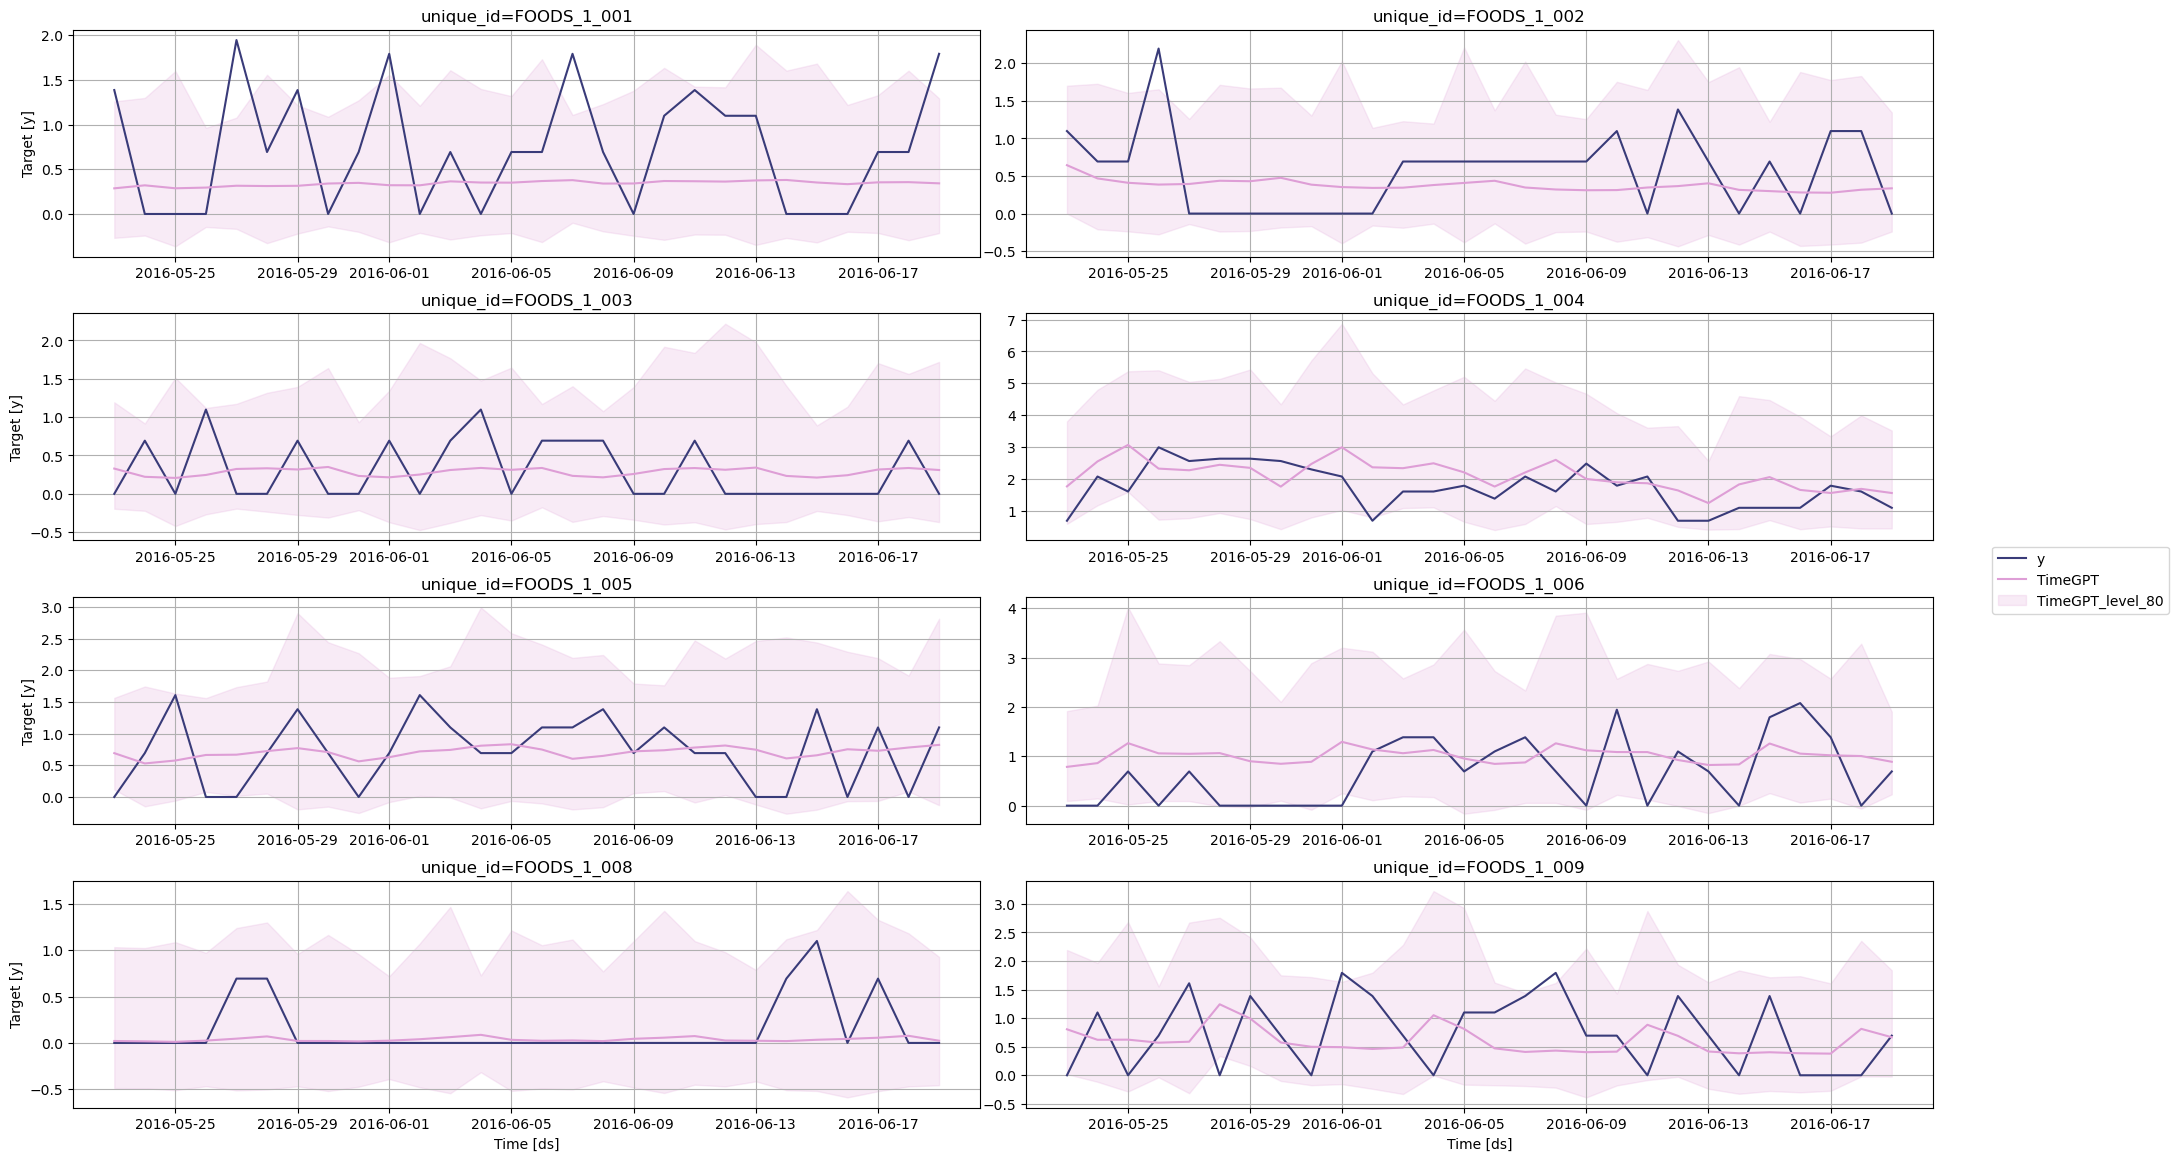

In [ ]:
nixtla_client.plot(test_df, fcst_df, models=['TimeGPT'], level=[80], time_col='ds', target_col='y')

Finally, we can measure the mean absolute error (MAE) of the model.

In [ ]:
fcst_df['ds'] = pd.to_datetime(fcst_df['ds'])

test_df = pd.merge(test_df, fcst_df, 'left', ['unique_id', 'ds'])

In [ ]:
evaluation = evaluate(
    test_df,
    metrics=[mae],
    models=["TimeGPT"],
    target_col="y",
    id_col='unique_id'
)

average_metrics = evaluation.groupby('metric')['TimeGPT'].mean()
average_metrics

metric
mae    0.492559
Name: TimeGPT, dtype: float64

## Forecasting with statistical models

The library `statsforecast` by Nixtla provides a suite of statistical models specifically built for intermittent forecasting, such as Croston, IMAPA and TSB. Let's use these models and see how they perform against TimeGPT.

In [ ]:
from statsforecast import StatsForecast
from statsforecast.models import CrostonClassic, CrostonOptimized, IMAPA, TSB

Here, we use four models: two versions of Croston, IMAPA and TSB.

In [ ]:
models = [CrostonClassic(), CrostonOptimized(), IMAPA(), TSB(0.1, 0.1)]

sf = StatsForecast(
    models=models,
    freq='D',
    n_jobs=-1
)

Then, we can fit the models on our data.

In [ ]:
start = time.time()

sf.fit(df=input_df)

sf_preds = sf.predict(h=28)

end = time.time()

sf_duration = end - start

print(f"Statistical models took :{sf_duration}s")

Here, fitting and predicting with four statistical models took 5.2 seconds, while TimeGPT took 5.8 seconds, so TimeGPT was only 0.6 seconds slower.

Again, we need to inverse the transformation. Remember that the training data was previously transformed using the log function.

In [ ]:
cols = [col for col in sf_preds.columns if col not in ['ds', 'unique_id']]

for col in cols:
    sf_preds[col] = np.exp(sf_preds[col])-1

sf_preds.head()

,ds,CrostonClassic,CrostonOptimized,IMAPA,TSB
unique_id,,,,,
FOODS_1_001,2016-05-23,0.599093,0.599093,0.445779,0.396258
FOODS_1_001,2016-05-24,0.599093,0.599093,0.445779,0.396258
FOODS_1_001,2016-05-25,0.599093,0.599093,0.445779,0.396258
FOODS_1_001,2016-05-26,0.599093,0.599093,0.445779,0.396258
FOODS_1_001,2016-05-27,0.599093,0.599093,0.445779,0.396258


## Evaluation

Now, let's combine the predictions from all methods and see which performs best.

In [ ]:
test_df = pd.merge(test_df, sf_preds, 'left', ['unique_id', 'ds'])
test_df.head()

,unique_id,ds,y,sell_price,event_type_Cultural,event_type_National,event_type_Religious,event_type_Sporting,TimeGPT,TimeGPT-lo-80,TimeGPT-hi-80,CrostonClassic,CrostonOptimized,IMAPA,TSB
0,FOODS_1_001,2016-05-23,1.386294,2.24,0,0,0,0,0.286841,-0.267101,1.259465,0.599093,0.599093,0.445779,0.396258
1,FOODS_1_001,2016-05-24,0.000000,2.24,0,0,0,0,0.320482,-0.241236,1.298046,0.599093,0.599093,0.445779,0.396258
2,FOODS_1_001,2016-05-25,0.000000,2.24,0,0,0,0,0.287392,-0.362250,1.598791,0.599093,0.599093,0.445779,0.396258
3,FOODS_1_001,2016-05-26,0.000000,2.24,0,0,0,0,0.295326,-0.145489,0.963542,0.599093,0.599093,0.445779,0.396258
4,FOODS_1_001,2016-05-27,1.945910,2.24,0,0,0,0,0.315868,-0.166516,1.077437,0.599093,0.599093,0.445779,0.396258


In [ ]:
evaluation = evaluate(
    test_df,
    metrics=[mae],
    models=["TimeGPT", "CrostonClassic", "CrostonOptimized", "IMAPA", "TSB"],
    target_col="y",
    id_col='unique_id'
)

average_metrics = evaluation.groupby('metric')[["TimeGPT", "CrostonClassic", "CrostonOptimized", "IMAPA", "TSB"]].mean()
average_metrics

,TimeGPT,CrostonClassic,CrostonOptimized,IMAPA,TSB
metric,,,,,
mae,0.492559,0.564563,0.580922,0.571943,0.567178


In the table above, we can see that TimeGPT achieves the lowest MAE, achieving a 12.8% improvement over the best performing statistical model.

Now, this was done without using any of the available exogenous features. While the statsitical models do not support them, let's try including them in TimeGPT.

## Forecasting with exogenous variables using TimeGPT

To forecast with exogenous variables, we need to specify their future values over the forecast horizon. Therefore, let's simply take the types of events, as those dates are known in advance. 

In [ ]:
futr_exog_df = test_df.drop(["TimeGPT", "CrostonClassic", "CrostonOptimized", "IMAPA", "TSB", "y", "TimeGPT-lo-80", "TimeGPT-hi-80", "sell_price"], axis=1)
futr_exog_df.head()

,unique_id,ds,event_type_Cultural,event_type_National,event_type_Religious,event_type_Sporting
0,FOODS_1_001,2016-05-23,0,0,0,0
1,FOODS_1_001,2016-05-24,0,0,0,0
2,FOODS_1_001,2016-05-25,0,0,0,0
3,FOODS_1_001,2016-05-26,0,0,0,0
4,FOODS_1_001,2016-05-27,0,0,0,0


Then, we simply call the `forecast` method and pass the `futr_exog_df` in the `X_df` parameter.

In [ ]:
start = time.time()

fcst_df = nixtla_client.forecast(
    df=input_df,
    X_df=futr_exog_df,
    h=28,                            
    level=[80],                        # Generate a 80% confidence interval
    finetune_steps=10,                 # Specify the number of steps for fine-tuning
    finetune_loss='mae',               # Use the MAE as the loss function for fine-tuning
    model='timegpt-1-long-horizon',    # Use the model for long-horizon forecasting
    time_col='ds',
    target_col='y',
    id_col='unique_id'
)

end = time.time()

timegpt_duration = end - start

print(f"Time (TimeGPT): {timegpt_duration}")

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Inferred freq: D
INFO:nixtla.nixtla_client:Using the following exogenous variables: event_type_Cultural, event_type_National, event_type_Religious, event_type_Sporting
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


Time (TimeGPT): 7.173351287841797


> 📘 Available models in Azure AI
>
> If you are using an Azure AI endpoint, please be sure to set `model="azureai"`:
>
> `nixtla_client.forecast(..., model="azureai")`
> 
> For the public API, we support two models: `timegpt-1` and `timegpt-1-long-horizon`. 
> 
> By default, `timegpt-1` is used. Please see [this tutorial](https://docs.nixtla.io/docs/tutorials-long_horizon_forecasting) on how and when to use `timegpt-1-long-horizon`.

Great! Remember that the predictions are transformed, so we have to inverse the transformation again.

In [ ]:
fcst_df.rename(columns={
    'TimeGPT': 'TimeGPT_ex',
}, inplace=True)

cols = [col for col in fcst_df.columns if col not in ['ds', 'unique_id']]

for col in cols:
    fcst_df[col] = np.exp(fcst_df[col])-1

fcst_df.head()

,unique_id,ds,TimeGPT_ex,TimeGPT-lo-80,TimeGPT-hi-80
0,FOODS_1_001,2016-05-23,0.281922,-0.269902,1.250828
1,FOODS_1_001,2016-05-24,0.313774,-0.245091,1.286372
2,FOODS_1_001,2016-05-25,0.285639,-0.363119,1.595252
3,FOODS_1_001,2016-05-26,0.295037,-0.145679,0.963104
4,FOODS_1_001,2016-05-27,0.315484,-0.166760,1.076830


## Evaluation

Finally, let's evaluate the performance of TimeGPT with exogenous features.

In [ ]:
test_df['TimeGPT_ex'] = fcst_df['TimeGPT_ex'].values
test_df.head()

,unique_id,ds,y,sell_price,event_type_Cultural,event_type_National,event_type_Religious,event_type_Sporting,TimeGPT,TimeGPT-lo-80,TimeGPT-hi-80,CrostonClassic,CrostonOptimized,IMAPA,TSB,TimeGPT_ex
0,FOODS_1_001,2016-05-23,1.386294,2.24,0,0,0,0,0.286841,-0.267101,1.259465,0.599093,0.599093,0.445779,0.396258,0.281922
1,FOODS_1_001,2016-05-24,0.000000,2.24,0,0,0,0,0.320482,-0.241236,1.298046,0.599093,0.599093,0.445779,0.396258,0.313774
2,FOODS_1_001,2016-05-25,0.000000,2.24,0,0,0,0,0.287392,-0.362250,1.598791,0.599093,0.599093,0.445779,0.396258,0.285639
3,FOODS_1_001,2016-05-26,0.000000,2.24,0,0,0,0,0.295326,-0.145489,0.963542,0.599093,0.599093,0.445779,0.396258,0.295037
4,FOODS_1_001,2016-05-27,1.945910,2.24,0,0,0,0,0.315868,-0.166516,1.077437,0.599093,0.599093,0.445779,0.396258,0.315484


In [ ]:
evaluation = evaluate(
    test_df,
    metrics=[mae],
    models=["TimeGPT", "CrostonClassic", "CrostonOptimized", "IMAPA", "TSB", "TimeGPT_ex"],
    target_col="y",
    id_col='unique_id'
)

average_metrics = evaluation.groupby('metric')[["TimeGPT", "CrostonClassic", "CrostonOptimized", "IMAPA", "TSB", "TimeGPT_ex"]].mean()
average_metrics

,TimeGPT,CrostonClassic,CrostonOptimized,IMAPA,TSB,TimeGPT_ex
metric,,,,,,
mae,0.492559,0.564563,0.580922,0.571943,0.567178,0.485352


From the table above, we can see that using exogenous features improved the performance of TimeGPT. Now, it represents a 14% improvement over the best statistical model. 

Using TimeGPT with exogenous features took 6.8 seconds. This is 1.6 seconds slower than statitstical models, but it resulted in much better predictions.